
=== Additive ===


/tmp/ipykernel_2761433/1664746787.py:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  w = (np.math.factorial(len(S)) *
/tmp/ipykernel_2761433/1664746787.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  np.math.factorial(d - len(S) - 2)) / np.math.factorial(d - 1)


pair (0, 1) | SII=0.0000 | STI=0.0000
pair (0, 2) | SII=0.0000 | STI=0.0000
pair (1, 2) | SII=0.0000 | STI=0.0000

=== Multiplicative x0*x1 ===
pair (0, 1) | SII=2.0000 | STI=2.0000
pair (0, 2) | SII=0.0000 | STI=0.0000
pair (1, 2) | SII=0.0000 | STI=0.0000

=== x0*x1 + x1*x2 ===
pair (0, 1) | SII=2.0000 | STI=2.0000
pair (0, 2) | SII=0.0000 | STI=0.0000
pair (1, 2) | SII=6.0000 | STI=6.0000


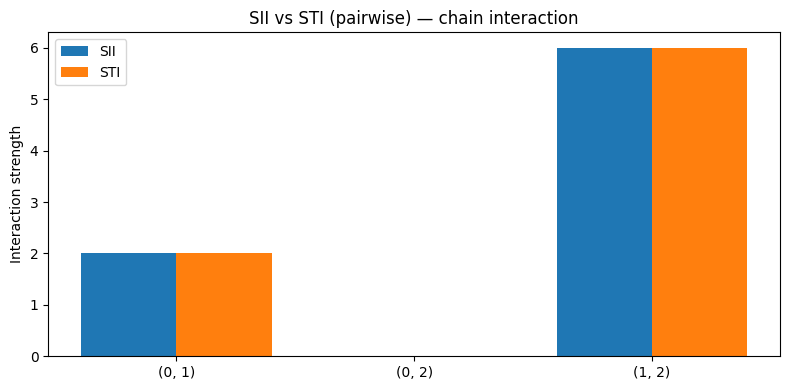

In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm

# -------------------------------
# Utilities
# -------------------------------

def mask_x(x, keep, baseline=0.0):
    x = x.clone()
    x[~keep] = baseline
    return x

def value_fn(model, x, keep):
    xm = mask_x(x, keep)
    return model(xm)

def all_subsets(s):
    s = list(s)
    out = []
    for i in range(1 << len(s)):
        out.append({s[j] for j in range(len(s)) if (i >> j) & 1})
    return out

# -------------------------------
# Exact SII (pairwise)
# -------------------------------

def sii_pairwise(model, x, i, j):
    """
    Exact Shapley Interaction Index Φ_{i,j}
    """
    d = x.numel()
    N = set(range(d))
    rest = N - {i, j}
    val = 0.0

    for S in all_subsets(rest):
        S = set(S)
        w = (np.math.factorial(len(S)) *
             np.math.factorial(d - len(S) - 2)) / np.math.factorial(d - 1)

        def v(A):
            keep = th.zeros(d, dtype=th.bool)
            for k in A:
                keep[k] = True
            return value_fn(model, x, keep)

        delta = (
            v(S | {i, j})
            - v(S | {i})
            - v(S | {j})
            + v(S)
        )
        val += w * delta.item()
    return val

# -------------------------------
# STI(2) via permutations
# -------------------------------

def sti_pairwise(model, x, i, j, K=2000):
    """
    Shapley–Taylor interaction (order 2)
    """
    d = x.numel()
    N = list(range(d))
    acc = 0.0

    for _ in range(K):
        perm = np.random.permutation(N)
        pos_i = np.where(perm == i)[0][0]
        pos_j = np.where(perm == j)[0][0]
        cutoff = min(pos_i, pos_j)
        S = set(perm[:cutoff])

        def v(A):
            keep = th.zeros(d, dtype=th.bool)
            for k in A:
                keep[k] = True
            return value_fn(model, x, keep)

        acc += (
            v(S | {i, j})
            - v(S | {i})
            - v(S | {j})
            + v(S)
        ).item()

    return acc / K

# -------------------------------
# Models
# -------------------------------

class Additive(nn.Module):
    def __init__(self, w):
        super().__init__()
        self.w = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return (self.w * x).sum()

class Multiplicative(nn.Module):
    def forward(self, x):
        return x[0] * x[1]

class ChainInteraction(nn.Module):
    def forward(self, x):
        return x[0] * x[1] + x[1] * x[2]

# -------------------------------
# Experiments
# -------------------------------

def run_experiment(model, name):
    x = th.tensor([1.0, 2.0, 3.0])
    pairs = list(combinations(range(len(x)), 2))

    sii_vals = {}
    sti_vals = {}

    print(f"\n=== {name} ===")
    for i, j in pairs:
        sii = sii_pairwise(model, x, i, j)
        sti = sti_pairwise(model, x, i, j)
        sii_vals[(i, j)] = sii
        sti_vals[(i, j)] = sti
        print(f"pair {(i,j)} | SII={sii:.4f} | STI={sti:.4f}")

    return sii_vals, sti_vals

# -------------------------------
# Run tests
# -------------------------------

np.random.seed(0)
th.manual_seed(0)

# Test A: additive
sii_A, sti_A = run_experiment(Additive(th.tensor([1.0, -2.0, 0.5])), "Additive")

# Test B: pure multiplicative
sii_B, sti_B = run_experiment(Multiplicative(), "Multiplicative x0*x1")

# Test C: chain interaction
sii_C, sti_C = run_experiment(ChainInteraction(), "x0*x1 + x1*x2")

# -------------------------------
# Plot comparison (Test C)
# -------------------------------

pairs = list(sii_C.keys())
sii_vals = [sii_C[p] for p in pairs]
sti_vals = [sti_C[p] for p in pairs]

xpos = np.arange(len(pairs))
plt.figure(figsize=(8,4))
plt.bar(xpos - 0.2, sii_vals, width=0.4, label="SII")
plt.bar(xpos + 0.2, sti_vals, width=0.4, label="STI")
plt.xticks(xpos, [str(p) for p in pairs])
plt.ylabel("Interaction strength")
plt.title("SII vs STI (pairwise) — chain interaction")
plt.legend()
plt.tight_layout()
plt.show()
